In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import datetime
import random
from scipy import stats
import math
import nbimporter
from Modelling_utils import custom_distance

import seaborn as sns

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
pd.options.display.max_rows = 4000

In [2]:
font = {'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results/'

## Find the optimal distribution for fitting MiD long distance with custom error function

In [4]:
# MiD data reading
df_MiD=pd.read_csv('data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2'])
#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
# Different transport modes extraction
df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([20,21,22,23])==True]
df_MiD_car=df_MiD[df_MiD.hvm.isin([4]) == True] #Car
# long range concat
df_MiD_LR=pd.concat([df_MiD_car,df_MiD_LRpublic])

df_vec=df_MiD_LR['wegkm'].copy()
min_distance=100
max_distance=900
df_vec=df_vec[df_vec.between(min_distance,max_distance)]
print("MiD dataset size used: ",len(df_vec))

MiD dataset size used:  11008


In [5]:
"""
Fit distributions using custom distance function

Args:
- original_data: Original dataset
- distribution_candidates: List of scipy distributions to test
- sample_size: Size of synthetic data to generate for comparison

Returns:
- Best distribution and its parameters
"""
def fit_distribution(original_data, distribution_candidates, sample_size,max_d,num):
    best_distribution = None
    best_params = None
    results={}
    
    for dist in distribution_candidates:
        # Estimate distribution parameters
        try:
            # Different fitting methods for different distributions
            if dist == stats.norm:
                params = dist.fit(original_data)
            elif dist == stats.lognorm:
                # For lognormal, fit requires special handling
                params = dist.fit(original_data, floc=0)
            else:
                params = dist.fit(original_data)
            
            # Generate synthetic data from fitted distribution
            # print("params:",params)
            dist_name = dist.__class__.__name__.lower().replace('_gen', '')
            # print(dist_name)
            synthetic_data = dist.rvs(*params, size=sample_size)
            
            # Compute custom distance
            distance = custom_distance(original_data, synthetic_data,max_d,num)
            
            # Store results
            results[dist_name] = {
                'synthetic_data': synthetic_data,
                'error': distance,
                'params': params
            }
                
        except Exception as e:
            print(f"Fitting {dist.name} failed: {e}")
            continue
    
    return results


In [10]:
"""
Plot Complementary Cumulative Distribution Function (CCDF)
for original data and synthetic distributions
"""
def plot_ccdf(original_data, dist_results,normal=True):
    fig, ax = plt.subplots(figsize=(3.54*2.6,2.83*1.7))
    
    # CCDF for original data
    original_sorted = np.sort(original_data)
    original_ccdf = 1 - np.linspace(0, 1, len(original_sorted),endpoint=False)
    ax.plot(original_sorted, original_ccdf, label='Empirical data', color='#1f77b4',linestyle='solid', markersize=5,alpha=0.8,linewidth=4)
    
    # CCDF for synthetic data from each distribution
    for dist_name, result in dist_results.items():
        synthetic_data = result['synthetic_data']
        synthetic_sorted = np.sort(synthetic_data)
        synthetic_ccdf = 1 - np.linspace(0, 1, len(synthetic_sorted))
        print(dist_name,result['error'])
        # mapping the distribution name
        mapping={"expon" : "Exponential",
                "lognorm" : "Log-normal",
                "gamma" : "Gamma",
                "beta" : "Beta"}
        ax.plot(synthetic_sorted, synthetic_ccdf, label=mapping.get(dist_name),markersize=2,alpha=0.8,linewidth=3)
    
    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    plt.legend()
    
    if normal:
        leg = ax.legend(title='MiD Long Distance',loc='upper right',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.xlim(left=1e+2,right=2e+3)
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'Fitted distributions_normal.pdf', dpi=100, bbox_inches='tight')
    else:
        plt.yscale("log")
        plt.xscale("log")
        leg = ax.legend(title='MiD Long Distance',loc='lower left',alignment='left')
        leg.get_title().set_fontsize('20')
        plt.xlim(left=1e+2,right=2e+3)
        plt.ylim(bottom=1e-03)
        # plt.grid()
        plt.tight_layout()
        plt.savefig(res+'Fitted distributions_log.pdf', dpi=100, bbox_inches='tight')


In [11]:
"""
Plot Complementary Cumulative Distribution Function (CCDF)
for original data and synthetic distributions
"""
def plot_ccdf_sub(original_data, dist_results,sub):
    fig, ax = plt.subplots(figsize=(3.54*1.5,2.83*1.5))
    
    # CCDF for original data
    original_sorted = np.sort(original_data)
    original_ccdf = 1 - np.linspace(0, 1, len(original_sorted),endpoint=False)
    ax.plot(original_sorted, original_ccdf, label='Empirical data', color='#1f77b4',linestyle='solid', markersize=5,alpha=0.8,linewidth=4)
    
    # CCDF for synthetic data from each distribution
    for dist_name, result in dist_results.items():
        synthetic_data = result['synthetic_data']
        synthetic_sorted = np.sort(synthetic_data)
        synthetic_ccdf = 1 - np.linspace(0, 1, len(synthetic_sorted))   
        ax.plot(synthetic_sorted, synthetic_ccdf, label=dist_name,markersize=2,alpha=0.8,linewidth=3)
    
    # plt.xlabel('Trip Length (km)')
    # plt.ylabel('CCDF')
    plt.xscale('log')
    plt.yscale('log')

     #------- plot the sub zoom plots
    if sub:
        plt.xlim(right=300)  
        plt.xlim(left=120)
        plt.ylim(top=1.02)
        plt.ylim(bottom=0.2)
        ax.set_xticks([120,200,300])
        plt.tight_layout()
        plt.savefig(res+'Fitted distributions_log_sub1.pdf', dpi=100, bbox_inches='tight')
    else:
        plt.xlim(right=1000)  
        plt.xlim(left=700)
        plt.ylim(top=0.05)
        plt.ylim(bottom=0.001)
        ax.set_xticks([700,800,900,1000])
        # close the minor ticks
        ax.xaxis.set_minor_locator(plt.NullLocator())
        
        plt.tight_layout()
        plt.savefig(res+'Fitted distributions_log_sub2.pdf', dpi=100, bbox_inches='tight')

In [12]:
# used for different linestyles and colors
from cycler import cycler
plt.rc('axes', prop_cycle=cycler('color', ['violet','red','#2ca02c','#ff7f0e']) + 
                                cycler('linestyle', ['dashdot', 'dotted', 'dashed',(0, (3,5,1,5,1,5))]))

expon 0.1465625337232782
lognorm 0.35173964697047816
gamma 0.12905308049587824
beta 0.08296170039848039


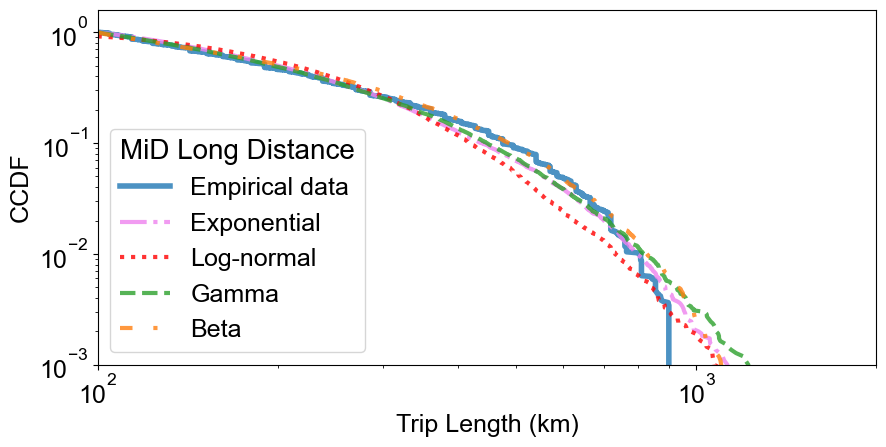

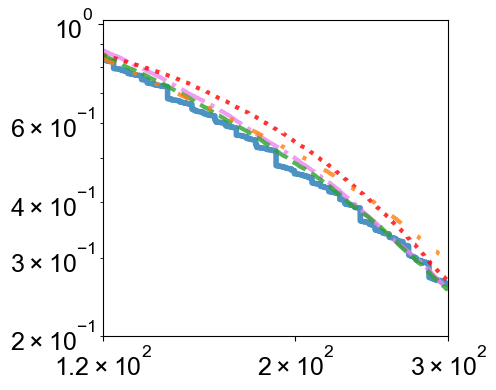

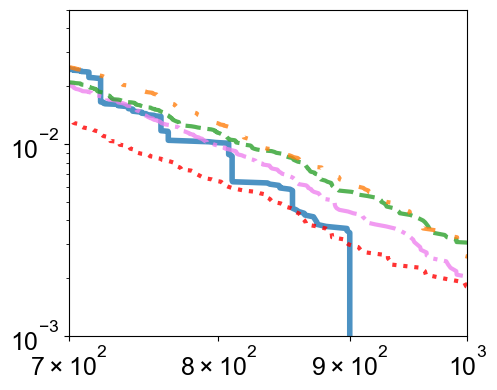

In [13]:
def main():

    original_data=df_vec
    
    # Distribution candidates
    distribution_candidates = [
        stats.expon,    
        stats.lognorm,     # Lognormal distribution
        stats.gamma,       # Gamma distribution
        stats.beta        # Beta distribution
#         stats.pareto
    ]
    max_d=800 # MiD: the maximum range of trip length for error cal in error function
    num=1000 # The number of sampling points in error calculation
    # Fit distribution
    dist_results = fit_distribution(
        original_data, 
        distribution_candidates,sample_size=len(original_data),max_d=max_d,num=num
    )
    
    # Plot CCDF
    plot_ccdf(original_data, dist_results,normal=False)
    plot_ccdf_sub(original_data, dist_results,True)
    plot_ccdf_sub(original_data, dist_results,False)

if __name__ == "__main__":
    main()